<div style="text-align: center; background-color: lightblue; padding: 15px;">
    <p style="text-align: center;">بسم الله، والحمد لله، والصلاة والسلام على رسول الله وعلى آله وصحبه</p>
</div>

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="text-align: center;">CUI</h2>
    <p><strong>PREPARE PAR L' ELEVE INGENIEUR:</strong></p>
    <ul>
        <li>Afaf ALOUI</li>
        <li>Fadoua HAIDA</li>
        <li>MOHAMED ELBADRI</li>
    </ul>
</div>

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> A- LOAD REQUIRED LIBRARIES </h4>
</div>

In [1]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import xarray as xr
import os
import metpy.constants as mpconst
from metpy.units import units 
import seaborn as sns
import xskillscore as xs
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
# widgets.IntSlider()

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> B- PREPARE INPUTS </h4>
</div>

<div class="note" style="background-color: teal; color: white; padding: 10px; border-radius: 5px;">
  <h4> B-1 CITIES </h4>
</div>

In [2]:
CITY = {
    'Dakhla': 15.5,
    'Laayoune': 19.5,
    'Tarfaya': 21.5,
    'Agadir': 23.5,
    'Essaouira': 25.5,
    'El Jadida': 27.5,
    'Casablanca': 29.5,
    'Mohammedia': 31.5,
    'Rabat': 32.5,
    'Skhirat': 33.5,
    'Tangier': 35.5,
    'Asilah': 37.5,
    'Larache': 39.5,
    'Ksar es seghir': 41.5
}

<div class="note" style="background-color: teal; color: white; padding: 10px; border-radius: 5px;">
  <h4> B-2 NAO </h4>
</div>

In [3]:
DATAIN = "/home/mohamed/EHTPIII/CLIMATOLOGIE/DATA/INOUT/"
def load_nao_data(file_path):
    """
    Charge et prépare les données NAO à partir d'un fichier texte.
    
    Args:
        file_path (str): Chemin vers le fichier NAO
        
    Returns:
        pd.DataFrame: DataFrame contenant les données NAO mensuelles indexées par date
    """
    nao_data = pd.read_csv(file_path, delim_whitespace=True)
    nao_monthly = pd.DataFrame()
    
    for year in nao_data['YEAR'].unique():
        year_data = nao_data[nao_data['YEAR'] == year]
        for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
            date = pd.to_datetime(f"{year}-{month}-01").strftime("%Y-%m")  
            nao_monthly.loc[date, 'NAO'] = year_data[month].values[0]
    
    # Réinitialiser l'index pour ajouter la colonne 'Date'
    nao_monthly.reset_index(inplace=True)
    nao_monthly.rename(columns={'index': 'Date'}, inplace=True)  # Renommer la colonne d'index

    # Convertir la colonne 'Date' en datetime
    nao_monthly['Date'] = pd.to_datetime(nao_monthly['Date'])


    return nao_monthly

# Utiliser la fonction pour charger les données NAO
nao_monthly = load_nao_data(DATAIN+"NAO.txt")

# Sauvegarder dans un fichier CSV avec le séparateur tab
nao_monthly.to_csv(DATAIN+"NAO_2.csv", sep=',', index=False)

/tmp/ipykernel_15559/2101350512.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao_data = pd.read_csv(file_path, delim_whitespace=True)


In [4]:
NAO=pd.read_csv(DATAIN+'NAO_2.csv')
NAO['Date'] = pd.to_datetime(NAO['Date'])
NAO.Date=NAO.Date.dt.to_period("M")
NAO['Date']=NAO['Date'].dt.to_timestamp()
NAO.rename(columns={'Date':'time'},inplace=True)
NAO

,time,NAO
0,1950-01-01,0.92
1,1950-02-01,0.40
2,1950-03-01,-0.36
3,1950-04-01,0.73
4,1950-05-01,-0.59
...,...,...
895,2024-08-01,0.63
896,2024-09-01,NaN
897,2024-10-01,NaN
898,2024-11-01,NaN


<div class="note" style="background-color: teal; color: white; padding: 10px; border-radius: 5px;">
  <h4> B-3 CUI </h4>
</div>

In [5]:
UI=pd.read_csv("/home/mohamed/EHTPIII/CLIMATOLOGIE/DATA/UI.csv")
UI['longitude'] = pd.to_numeric(UI['longitude'], errors='coerce')
UI=UI.iloc[1:]
ektrx=pd.to_numeric(UI.ektrx,errors='coerce')
ektry=pd.to_numeric(UI.ektry,errors='coerce')
coast_angle=135

def upwell(ektrx, ektry, coast_angle):
  import numpy as np
  pi = 3.1415927
  degtorad = pi/180.
  alpha = (360 - coast_angle) * degtorad
  s1 = np.cos(alpha)
  t1 = np.sin(alpha)
  s2 = -1 * t1
  t2 = s1
  perp = (s1 * ektrx) + (t1 * ektry)
  para = (s2 * ektrx) + (t2 * ektry)
  return(perp/10)


CUI=UI.copy()
CUI["CUI"]=upwell(ektrx, ektry, coast_angle)
CUI.time=pd.to_datetime(CUI.time)
CUI["latitude"]=pd.to_numeric(CUI["latitude"],errors='coerce')
CUI=CUI.groupby(['time','latitude'])['CUI'].mean().reset_index()
CUI=CUI[CUI['latitude'].isin(CITY.values())]
latitude_to_city={v: k for k, v in CITY.items()}
CUI["city"]=CUI['latitude'].map(latitude_to_city)
CUI["time"]=pd.to_datetime(CUI["time"]).dt.to_period("M")
CUI["time"]=CUI["time"].dt.to_timestamp()
CUI['city'] = CUI['city'].astype('string')
CUI=pd.merge(CUI,NAO).dropna()
CUI

/tmp/ipykernel_15559/2355963580.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  UI=pd.read_csv("/home/mohamed/EHTPIII/CLIMATOLOGIE/DATA/UI.csv")
/tmp/ipykernel_15559/2355963580.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  CUI["time"]=pd.to_datetime(CUI["time"]).dt.to_period("M")


,time,latitude,CUI,city,NAO
0,1967-01-01,15.5,-332.506976,Dakhla,-0.89
1,1967-01-01,19.5,-126.363259,Laayoune,-0.89
2,1967-01-01,21.5,-88.743291,Tarfaya,-0.89
3,1967-01-01,23.5,-85.539639,Agadir,-0.89
4,1967-01-01,25.5,-79.480394,Essaouira,-0.89
...,...,...,...,...,...
9683,2024-08-01,33.5,8.276812,Skhirat,0.63
9684,2024-08-01,35.5,20.741580,Tangier,0.63
9685,2024-08-01,37.5,27.598799,Asilah,0.63
9686,2024-08-01,39.5,22.166739,Larache,0.63


<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> C- PLOTS</h4>
</div>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cui(city):

    fig, ax = plt.subplots(figsize=(25, 10))
    DF=CUI.query("city==@city")

    ax=sns.lineplot(data=DF, x="time", y="CUI", ax=ax, label="CUI", color="tab:blue")
    ax.set_ylabel("CUI", fontsize=14)
    ax.set_ylim(DF["CUI"].min() * 1.2, DF["CUI"].max() * 1.2) 
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    ax2 = ax.twinx()
    ax2=sns.lineplot(data=DF, x="time", y="NAO", ax=ax2, label="NAO", color="tab:red")
    ax2.set_ylabel("NAO", fontsize=14)
    ax2.set_ylim(DF["NAO"].min() * 1.2, DF["NAO"].max() * 1.2) 
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    plt.title("CUI and NAO Over Time", fontsize=18)
    ax.legend(loc="upper left", fontsize=12)
    ax2.legend(loc="upper right", fontsize=12)
    plt.show()
city_dropdown=widgets.Dropdown(options=CITY.keys(),value="Dakhla")
widgets.interactive(plot_cui,city=city_dropdown)

interactive(children=(Dropdown(description='city', options=('Dakhla', 'Laayoune', 'Tarfaya', 'Agadir', 'Essaou…

In [7]:
# Extract the Upwelling Index for Tangier using the coordinates for longitude and latitude
def UIC_PLOT(city):
    fig,ax=plt.subplots(figsize=(20, 7))
    DF=CUI.copy()
    cui=DF.query("city==@city").loc[:,"CUI"]
    nao=DF.query("city==@city").loc[:,"NAO"]
    t=DF.query("city==@city").loc[:,"time"]
    colors = ['lightblue' if val >= 0 else 'orange' for val in cui]

    ax.bar(t, cui, color=colors, width=5.0)
    ax.axhline(0, color='black', linewidth=2)
    ax.set_title(f'Upwelling Index for {city} ' , fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Upwelling Index', fontsize=14)
    ax.set_ylim(cui.min() * 1.2 , cui.max() * 1.2)
    ax.grid(visible=True, linestyle='--', alpha=0.2)
    
city_dropdown = widgets.Dropdown(options=CITY.keys(),description='City')
widgets.interactive(UIC_PLOT, city=city_dropdown)

interactive(children=(Dropdown(description='City', options=('Dakhla', 'Laayoune', 'Tarfaya', 'Agadir', 'Essaou…

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> D- CORRELATION</h4>
</div>

In [8]:
def corr_cui(city):
    cui=CUI.query("city==@city").loc[:,"CUI"]
    nao=CUI.query("city==@city").loc[:,"NAO"]
    corr=(np.corrcoef(cui,nao)[0, 1])
    return corr


In [9]:
dic_corr={"CITY":CITY.keys(),
          "CORR": [corr_cui(city) for city in CITY.keys()]
          }
df_corr=pd.DataFrame(data=dic_corr)
df_corr

,CITY,CORR
0,Dakhla,-0.225737
1,Laayoune,-0.236985
2,Tarfaya,-0.237240
3,Agadir,-0.240169
4,Essaouira,-0.239599
5,El Jadida,-0.208938
6,Casablanca,-0.170677
7,Mohammedia,-0.138385
8,Rabat,-0.133042
9,Skhirat,-0.129187


<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> E- EFFECT DE NAO +/-</h4>
</div>

In [10]:
CUI["month"]=CUI.time.dt.month
CUI_POS=CUI.query("NAO>0")
CUI_NEG=CUI.query("NAO<=0")

In [11]:
DF1=CUI_POS.groupby("month")["CUI"].mean().reset_index()
DF2=CUI_NEG.groupby("month")["CUI"].mean().reset_index()
DF1

,month,CUI
0,1,-29.519980
1,2,-15.934169
2,3,-0.346618
3,4,26.456448
4,5,36.605587
5,6,47.017195
6,7,46.926119
7,8,36.018474
8,9,16.909261
9,10,3.034648


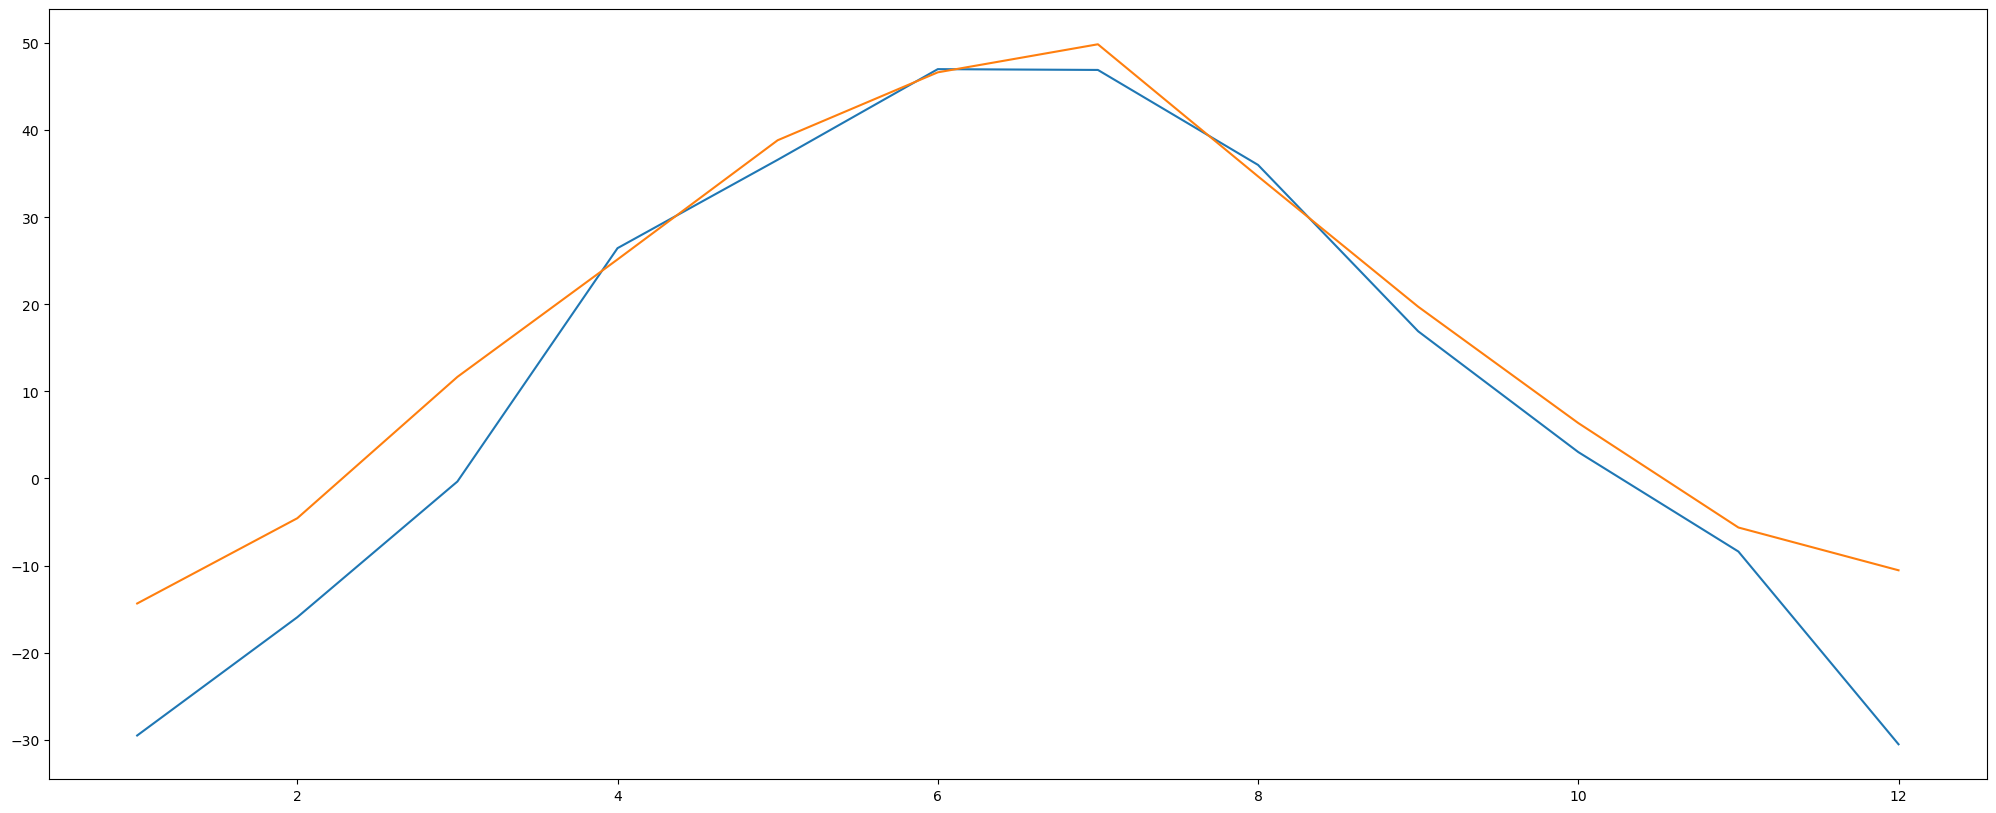

In [12]:
fig,ax=plt.subplots(figsize=(25,10))
ax.plot(DF1.month,DF1.CUI)
ax.plot(DF2.month,DF2.CUI)
ax.legend
plt.show()
# sns.lineplot(data=DF2,x="month",y="CUI")

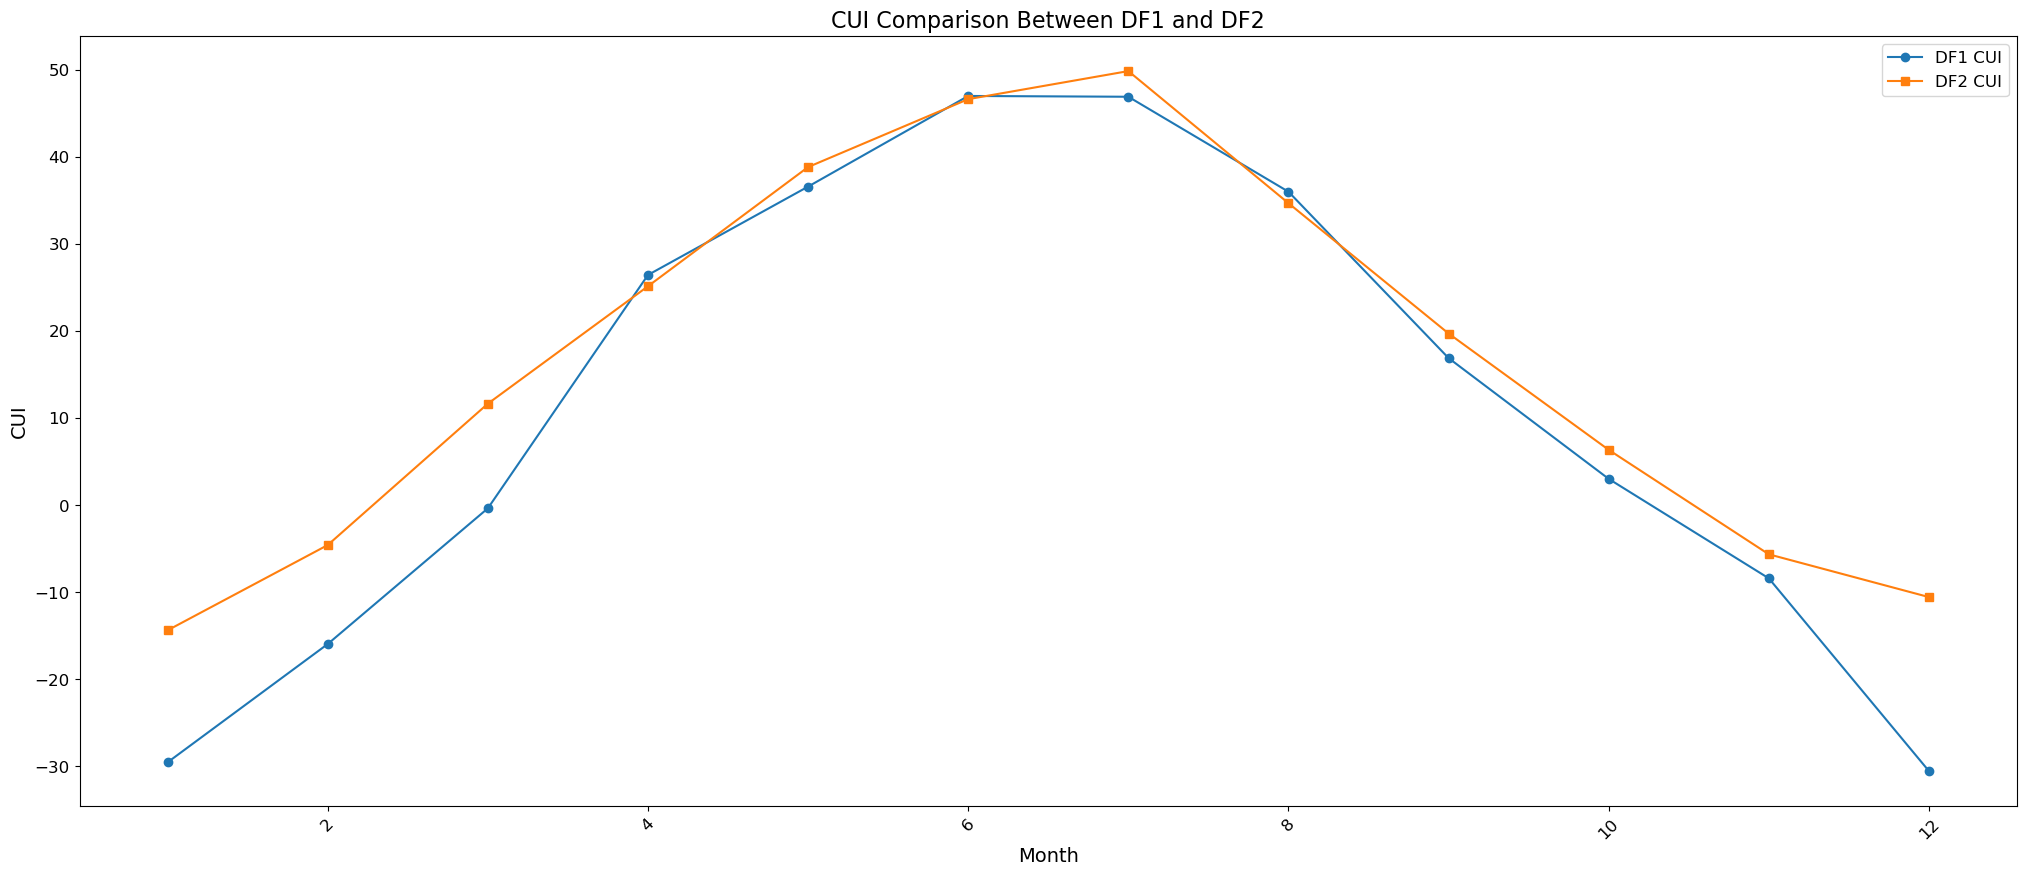

In [13]:
import matplotlib.pyplot as plt

# Example plotting code
fig, ax = plt.subplots(figsize=(25, 10))

# Plotting the data from both DataFrames
ax.plot(DF1['month'], DF1['CUI'], label='DF1 CUI', marker='o')
ax.plot(DF2['month'], DF2['CUI'], label='DF2 CUI', marker='s')

# Adding labels, legend, and title
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('CUI', fontsize=14)
ax.set_title('CUI Comparison Between DF1 and DF2', fontsize=16)
ax.legend(fontsize=12)

# Formatting x-axis (optional)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [14]:
SST=xr.open_dataset("/home/mohamed/EHTPIII/CLIMATOLOGIE/DATA/sst.nc")
SST

<xarray.Dataset> Size: 9MB
Dimensions:    (date: 540, latitude: 61, longitude: 65)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 4kB 19780101 19780201 19780301 ... 20221101 20221201
  * latitude   (latitude) float64 488B 36.0 35.75 35.5 35.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float64 520B -19.0 -18.75 -18.5 ... -3.5 -3.25 -3.0
    expver     (date) <U4 9kB ...
Data variables:
    sst        (date, latitude, longitude) float32 9MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-26T22:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
SST_DF=SST[['sst']].to_dataframe().reset_index()
SST_DF.dtypes

date           int64
latitude     float64
longitude    float64
sst          float32
number         int64
expver        object
dtype: object

In [16]:
from datetime import datetime
SST_DF['date'] = pd.to_datetime(SST_DF['date'], format='%Y%m%d')
SST_DF=SST_DF.filter(["date","latitude","longitude","sst"])
SST_DF["sst"]=SST_DF["sst"]-273.15

In [17]:
SST_DF

,date,latitude,longitude,sst
0,1978-01-01,36.0,-19.00,16.948395
1,1978-01-01,36.0,-18.75,16.917145
2,1978-01-01,36.0,-18.50,16.917145
3,1978-01-01,36.0,-18.25,16.907379
4,1978-01-01,36.0,-18.00,16.910309
...,...,...,...,...
2141095,2022-12-01,21.0,-4.00,NaN
2141096,2022-12-01,21.0,-3.75,NaN
2141097,2022-12-01,21.0,-3.50,NaN
2141098,2022-12-01,21.0,-3.25,NaN


In [61]:
CUI_ALL.city.unique()

<StringArray>
[   'Tangier',    'Skhirat',      'Rabat', 'Mohammedia', 'Casablanca',
  'El Jadida',  'Essaouira',     'Agadir',    'Tarfaya']
Length: 9, dtype: string

In [27]:
SST_DF.rename(columns={"date":"time"},inplace=True)
CUI_ALL=pd.merge(SST_DF,CUI)
CUI_ALL["month"]=CUI_ALL.time.dt.month

In [65]:
SST_POS=CUI_ALL.query("CUI>0")
SST_POS=SST_POS.groupby("month")["sst"].mean().reset_index()
SST_POS_ANOM=SST_POS-CUI_ALL.groupby("month")["sst"].mean().reset_index()
SST_NEG=CUI_ALL.query("CUI<0")
SST_NEG=SST_NEG.groupby("month")["sst"].mean().reset_index()
SST_NEG_ANOM=SST_NEG-CUI_ALL.groupby("month")["sst"].mean().reset_index()
CUI_INDEX=CUI_ALL.groupby("month")["CUI"].mean().reset_index()


In [62]:
# SST_POS=CUI_ALL.query("CUI>0  & city=='Agadir'")
# SST_POS=SST_POS.groupby("month")["sst"].mean().reset_index()
# SST_POS_ANOM=SST_POS-CUI_ALL.groupby("month")["sst"].mean().reset_index()
# SST_NEG=CUI_ALL.query("CUI<0 & city=='Agadir'")
# SST_NEG=SST_NEG.groupby("month")["sst"].mean().reset_index()
# SST_NEG_ANOM=SST_NEG-CUI_ALL.groupby("month")["sst"].mean().reset_index()
# CUI_INDEX=CUI_ALL.groupby("month")["CUI"].mean().reset_index()


In [63]:
SST_POS

,month,sst
0,1,19.818167
1,2,19.125153
2,3,18.960104
3,4,19.383327
4,5,19.834431
5,6,20.424488
6,7,20.989128
7,8,21.810249
8,9,22.238323
9,10,22.247923


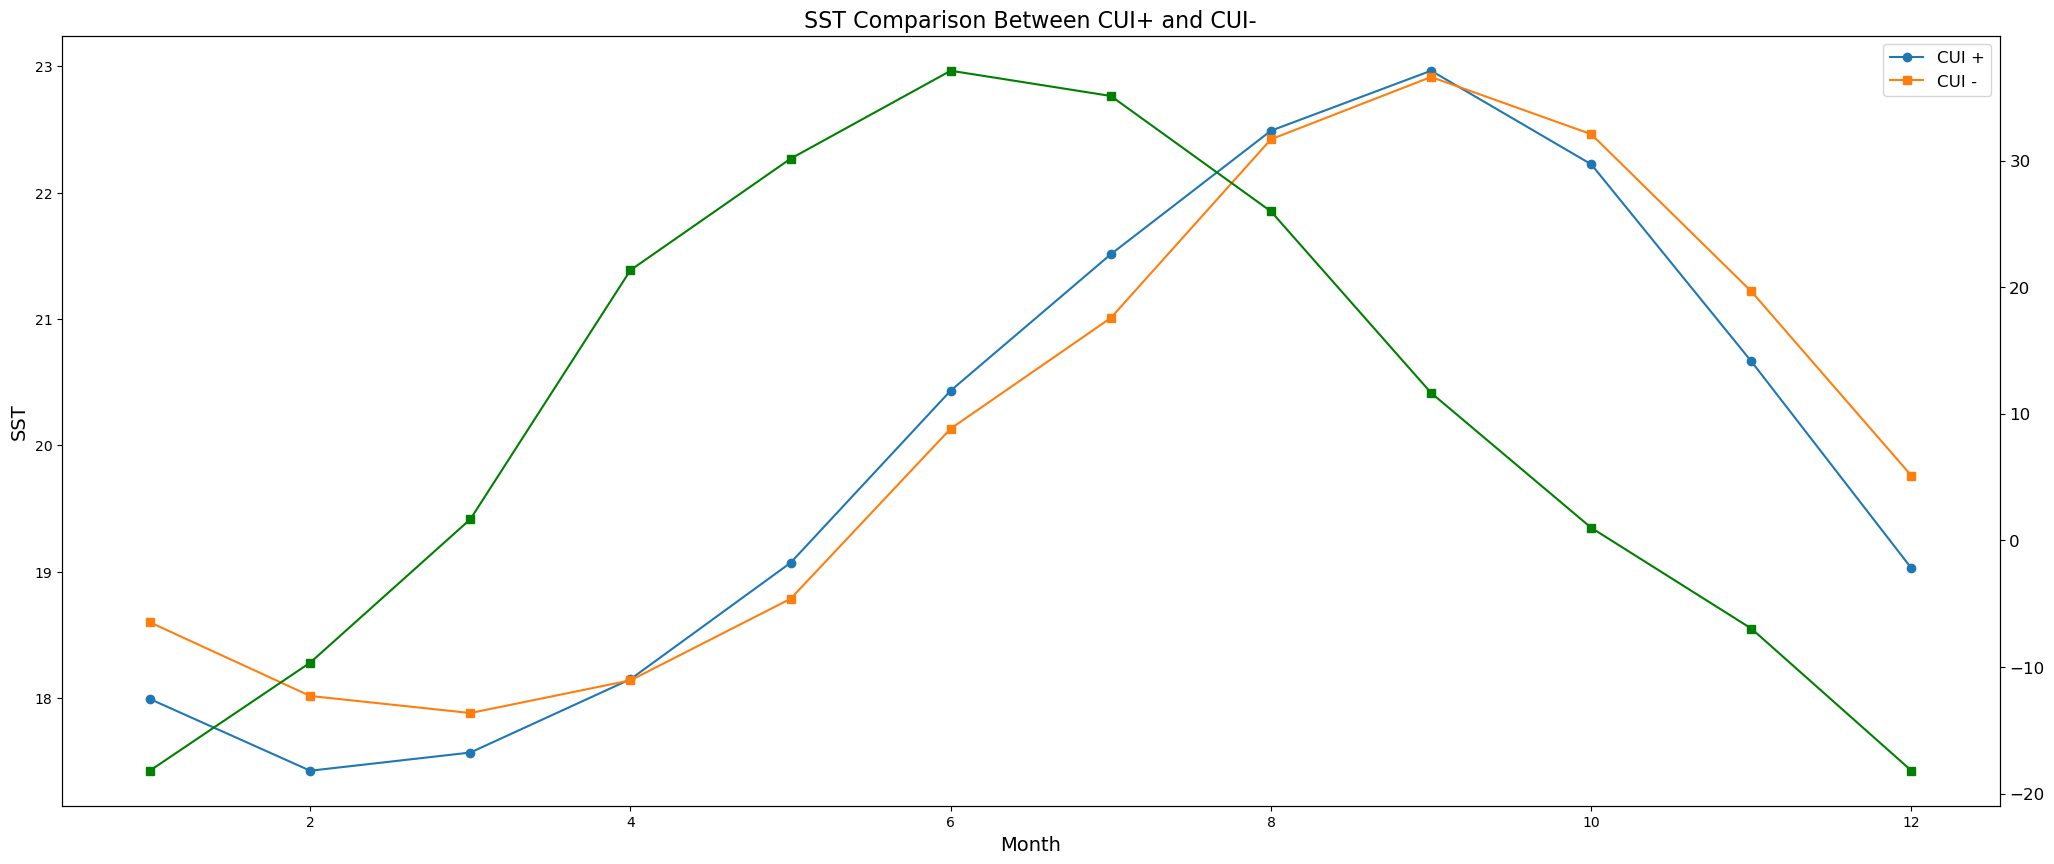

In [66]:
import matplotlib.pyplot as plt

# Example plotting code
fig, ax = plt.subplots(figsize=(25, 10))

# Plotting the data from both DataFrames
ax.plot(SST_POS['month'], SST_POS['sst'], label='CUI +', marker='o')
ax.plot(SST_NEG['month'], SST_NEG['sst'], label='CUI -', marker='s')
ax2=ax.twinx()
ax2.plot(CUI_INDEX['month'], CUI_INDEX['CUI'], label='CUI Index', marker='s',color="green")

# Adding labels, legend, and title
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('SST', fontsize=14)
ax.set_title('SST Comparison Between CUI+ and CUI-', fontsize=16)
ax.legend(fontsize=12)

# Formatting x-axis (optional)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [68]:
CUI_ALL.to_csv("CUI.csv")